# 03 - Exploratory Spatial Data Analysis (ESDA)

This notebook performs spatial analysis to identify patterns and clusters in the relationship between pain/distress metrics and Trump voting patterns.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Spatial analysis libraries
import libpysal
from libpysal.weights import Queen, Rook, KNN
import esda
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
import splot
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import mapclassify

# Setup
project_root = Path.cwd().parent
data_processed = project_root / 'data' / 'processed'
reports = project_root / 'reports'

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load Processed Data

In [2]:
# Load the merged county dataset
gdf = gpd.read_file(data_processed / 'counties_analysis.geojson')

print(f"Dataset shape: {gdf.shape}")
print(f"\nFirst 10 columns: {gdf.columns.tolist()[:10]}")
print(f"Geometry CRS: {gdf.crs}")

# Ensure we're using a projected CRS for accurate spatial calculations
if gdf.crs.to_epsg() == 4326:
    gdf = gdf.to_crs('EPSG:5070')  # Albers Equal Area for continental US
    print(f"Reprojected to: {gdf.crs}")

# Quick data summary
print(f"\nKey variables available:")
key_vars = ['trump_share_2016', 'trump_share_2020', 'od_1316_rate', 'od_1720_rate', 
            'freq_phys_distress_pct', 'depression_pct']
for var in key_vars:
    if var in gdf.columns:
        non_null = gdf[var].notna().sum()
        print(f"  {var}: {non_null}/{len(gdf)} ({non_null/len(gdf)*100:.1f}%) non-null")

Dataset shape: (3109, 61)

First 10 columns: ['fips', 'county_name', 'state_fips', 'trump_votes_2016', 'opponent_votes_2016', 'two_party_votes_2016', 'total_votes_2016', 'trump_share_2016', 'trump_margin_2016', 'trump_votes_2020']
Geometry CRS: EPSG:4326
Reprojected to: EPSG:5070

Key variables available:
  trump_share_2016: 3100/3109 (99.7%) non-null
  trump_share_2020: 3100/3109 (99.7%) non-null
  od_1316_rate: 0/3109 (0.0%) non-null
  od_1720_rate: 0/3109 (0.0%) non-null
  freq_phys_distress_pct: 3109/3109 (100.0%) non-null
  depression_pct: 3109/3109 (100.0%) non-null


## 2. Spatial Weights Matrix

In [3]:
def create_spatial_weights(gdf, weight_type='queen'):
    """Create spatial weights matrix"""
    
    if weight_type == 'queen':
        w = Queen.from_dataframe(gdf, use_index=True)
    elif weight_type == 'rook':
        w = Rook.from_dataframe(gdf, use_index=True)
    elif weight_type == 'knn':
        w = KNN.from_dataframe(gdf, k=8)
    else:
        raise ValueError(f"Unknown weight type: {weight_type}")
    
    # Row-standardize the weights
    w.transform = 'r'
    
    print(f"Spatial weights summary:")
    print(f"  - Type: {weight_type}")
    print(f"  - Number of observations: {w.n}")
    print(f"  - Average number of neighbors: {w.mean_neighbors:.2f}")
    print(f"  - Min neighbors: {w.min_neighbors}")
    print(f"  - Max neighbors: {w.max_neighbors}")
    print(f"  - Islands: {w.islands}")
    
    return w

# Create Queen contiguity weights (counties that share a border)
w_queen = create_spatial_weights(gdf, 'queen')

# Handle islands if any
if len(w_queen.islands) > 0:
    print(f"\nWarning: {len(w_queen.islands)} islands detected")
    print(f"Island indices: {w_queen.islands}")

Spatial weights summary:
  - Type: queen
  - Number of observations: 3109
  - Average number of neighbors: 5.94
  - Min neighbors: 1
  - Max neighbors: 14
  - Islands: []


## 3. Global Spatial Autocorrelation

Analyzing 6 variables: ['trump_share_2016', 'trump_share_2020', 'trump_shift_16_20', 'freq_phys_distress_pct', 'arthritis_pct', 'depression_pct']



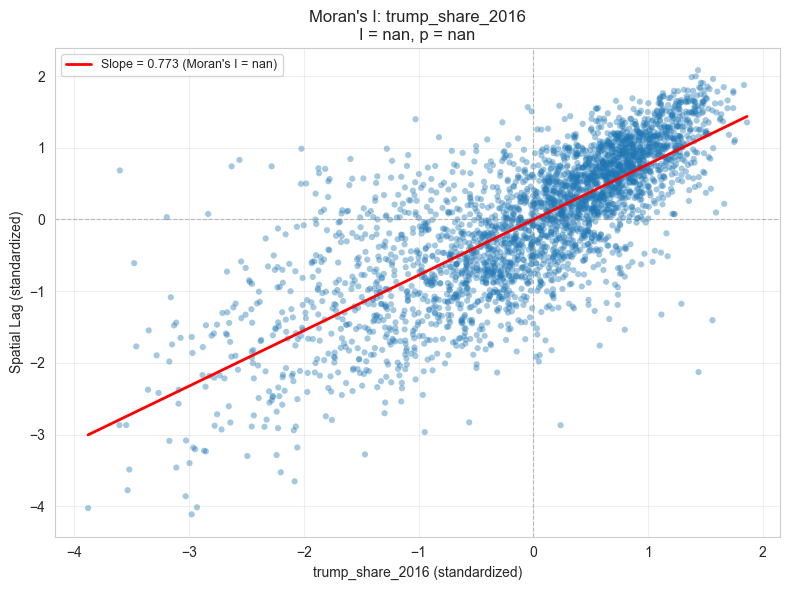

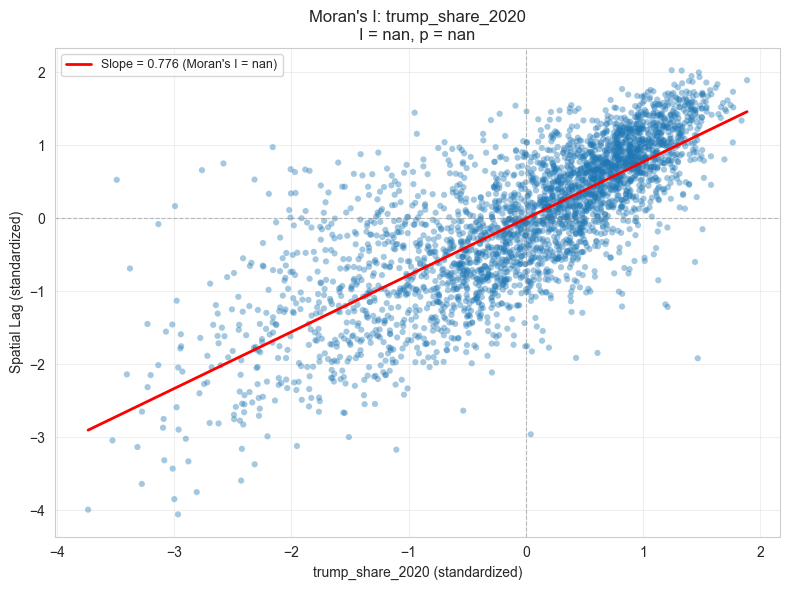

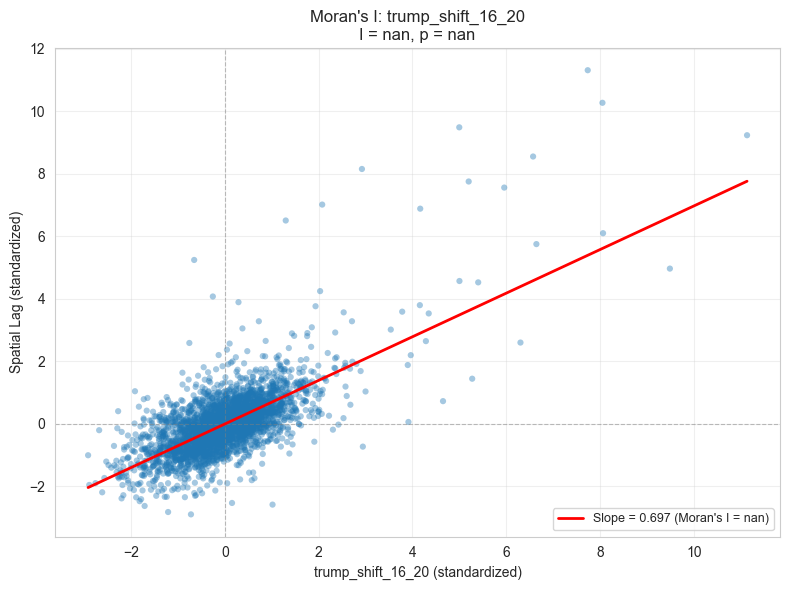

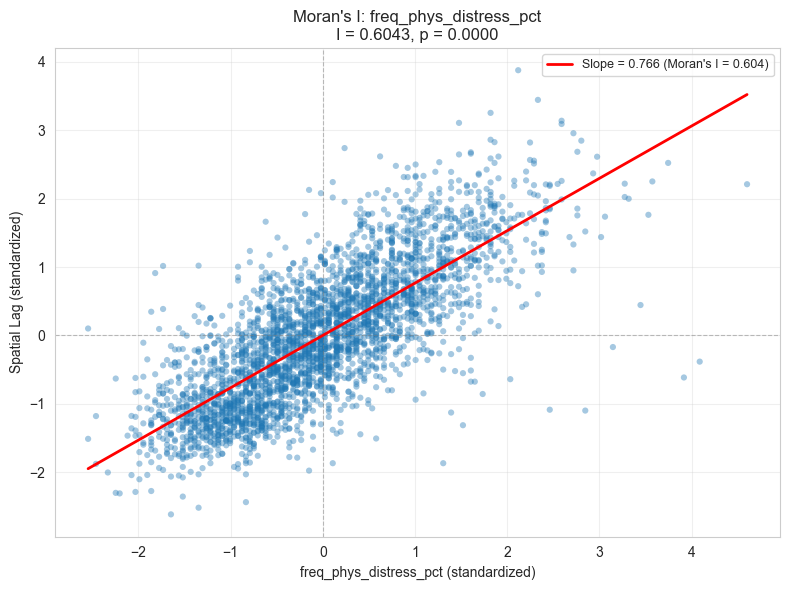

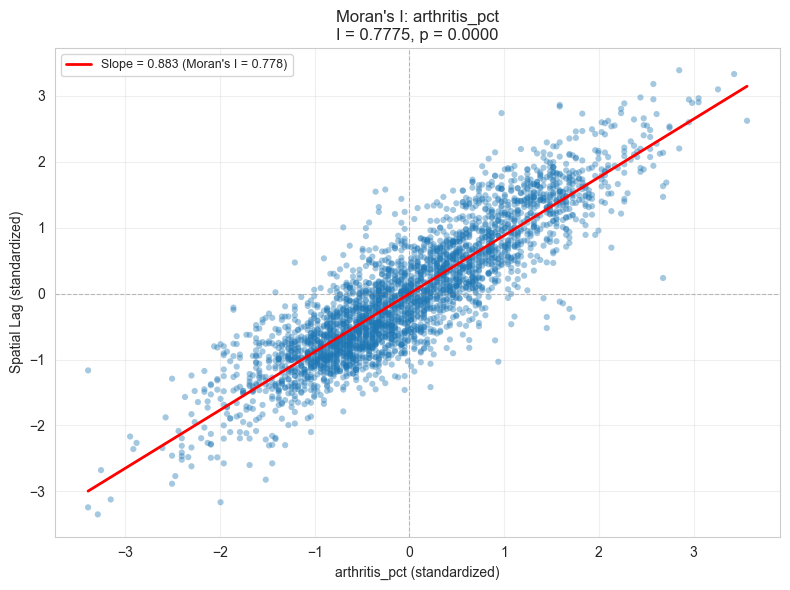

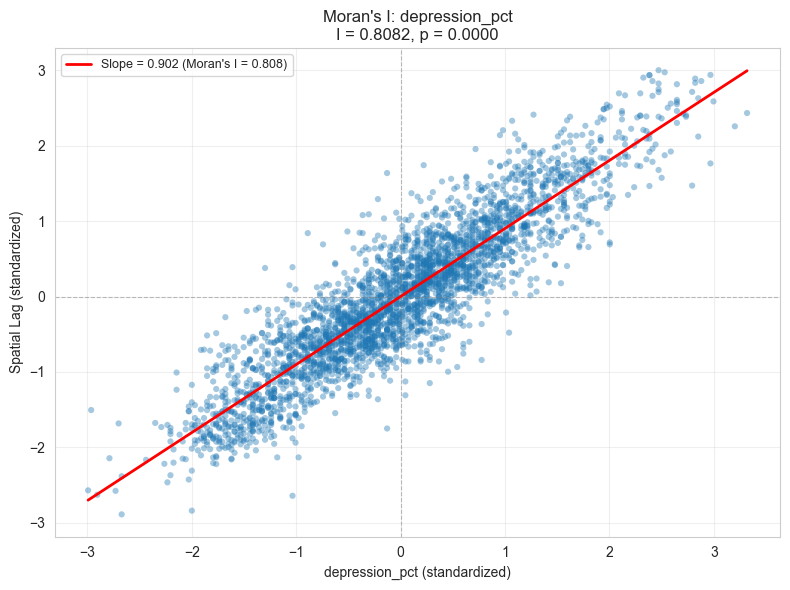

,variable,moran_i,expected_i,variance,z_score,p_value,p_value_sim,significant
5,depression_pct,0.808184,-0.000322,0.000112,76.385054,0.0,0.001,True
4,arthritis_pct,0.777510,-0.000322,0.000112,73.487098,0.0,0.001,True
3,freq_phys_distress_pct,0.604323,-0.000322,0.000112,57.124883,0.0,0.001,True
0,trump_share_2016,NaN,-0.000322,0.000112,NaN,NaN,0.001,False
1,trump_share_2020,NaN,-0.000322,0.000112,NaN,NaN,0.001,False
2,trump_shift_16_20,NaN,-0.000322,0.000112,NaN,NaN,0.001,False


In [6]:
def global_moran_analysis(gdf, w, variables):
    """Calculate Global Moran's I for multiple variables"""
    
    results = []
    
    for var in variables:
        if var in gdf.columns:
            # Check for sufficient non-null values
            valid_count = gdf[var].notna().sum()
            
            if valid_count < 30:
                print(f"Skipping {var}: insufficient non-null values ({valid_count})")
                continue
            
            # Calculate Moran's I (it handles NaN values internally)
            try:
                mi = Moran(gdf[var].values, w, permutations=999)
                
                # Get variance (handle different esda versions)
                variance = getattr(mi, 'VI_norm', getattr(mi, 'VI_rand', None))
                if variance is None:
                    variance = mi.seI_norm**2 if hasattr(mi, 'seI_norm') else np.nan
                
                results.append({
                    'variable': var,
                    'moran_i': mi.I,
                    'expected_i': mi.EI,
                    'variance': variance,
                    'z_score': mi.z_norm,
                    'p_value': mi.p_norm,
                    'p_value_sim': mi.p_sim,
                    'significant': mi.p_norm < 0.05
                })
                
                # Create manual Moran scatterplot (more robust with NaN handling)
                fig, ax = plt.subplots(1, 1, figsize=(8, 6))
                
                # Get the data
                y = gdf[var].values
                
                # Standardize (handling NaN)
                y_mean = np.nanmean(y)
                y_std_val = np.nanstd(y)
                y_standardized = (y - y_mean) / y_std_val
                
                # Calculate spatial lag
                y_lag = libpysal.weights.lag_spatial(w, y)
                y_lag_mean = np.nanmean(y_lag)
                y_lag_std_val = np.nanstd(y_lag)
                y_lag_standardized = (y_lag - y_lag_mean) / y_lag_std_val
                
                # Filter out NaN values for plotting
                valid_mask = ~np.isnan(y_standardized) & ~np.isnan(y_lag_standardized)
                x_plot = y_standardized[valid_mask]
                y_plot = y_lag_standardized[valid_mask]
                
                # Create scatter plot
                ax.scatter(x_plot, y_plot, alpha=0.4, s=20, edgecolors='none')
                
                # Add reference lines
                ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
                ax.axvline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
                
                # Add regression line
                if len(x_plot) > 1:
                    b, a = np.polyfit(x_plot, y_plot, 1)
                    x_line = np.array([x_plot.min(), x_plot.max()])
                    ax.plot(x_line, a + b * x_line, 'r-', linewidth=2, 
                           label=f'Slope = {b:.3f} (Moran\'s I = {mi.I:.3f})')
                
                ax.set_xlabel(f'{var} (standardized)', fontsize=10)
                ax.set_ylabel('Spatial Lag (standardized)', fontsize=10)
                ax.set_title(f"Moran's I: {var}\nI = {mi.I:.4f}, p = {mi.p_norm:.4f}", fontsize=12)
                ax.legend(fontsize=9)
                ax.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.savefig(reports / f'figures/moran_scatter_{var}.png', dpi=150, bbox_inches='tight')
                plt.show()
                
            except Exception as e:
                print(f"Error analyzing {var}: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    return pd.DataFrame(results)

# Define variables to analyze
spatial_vars = [
    'trump_share_2016',
    'trump_share_2020',
    'trump_shift_16_20',
    'od_1316_rate',
    'od_1720_rate',
    'od_rate_change',
    'freq_phys_distress_pct',
    'arthritis_pct',
    'depression_pct'
]

# Filter to variables that exist and have sufficient data
available_vars = [v for v in spatial_vars if v in gdf.columns and gdf[v].notna().sum() > 100]
print(f"Analyzing {len(available_vars)} variables: {available_vars}\n")

# Run global Moran analysis
moran_results = global_moran_analysis(gdf, w_queen, available_vars)
display(moran_results.sort_values('moran_i', ascending=False))

## 4. Local Spatial Autocorrelation (LISA)

## 3.5 Bivariate Choropleth Maps

Bivariate maps show two variables simultaneously to reveal their geographic relationship.


In [ ]:
def create_bivariate_choropleth(gdf, var1, var2, var1_label, var2_label, n_classes=3):
    """
    Create a bivariate choropleth map showing two variables simultaneously.
    
    Parameters:
    -----------
    var1 : str - First variable (shown on Y-axis, typically Trump support)
    var2 : str - Second variable (shown on X-axis, typically distress/pain)
    var1_label : str - Label for var1
    var2_label : str - Label for var2
    n_classes : int - Number of classes per variable (2 or 3 recommended)
    """
    import matplotlib.patches as mpatches
    
    # Filter to non-null values
    plot_gdf = gdf[[var1, var2, 'geometry']].copy()
    plot_gdf = plot_gdf.dropna(subset=[var1, var2])
    
    # Classify each variable into quantiles
    plot_gdf[f'{var1}_class'] = pd.qcut(plot_gdf[var1], q=n_classes, labels=False, duplicates='drop')
    plot_gdf[f'{var2}_class'] = pd.qcut(plot_gdf[var2], q=n_classes, labels=False, duplicates='drop')
    
    # Create bivariate class (combines both classifications)
    plot_gdf['bv_class'] = plot_gdf[f'{var1}_class'].astype(str) + '-' + plot_gdf[f'{var2}_class'].astype(str)
    
    # Define 3x3 color matrix (rows=var1 increasing, cols=var2 increasing)
    if n_classes == 3:
        # Custom color scheme: Blue (low-low) to Red (high-high)
        colors_3x3 = {
            '0-0': '#e8e8e8',  # Low-Low (light gray)
            '0-1': '#d4b9da',  # Low-Med (light purple)
            '0-2': '#c994c7',  # Low-High (purple)
            '1-0': '#fdbb84',  # Med-Low (light orange)
            '1-1': '#df65b0',  # Med-Med (medium purple)
            '1-2': '#ce1256',  # Med-High (red-purple)
            '2-0': '#fc8d59',  # High-Low (orange)
            '2-1': '#dd1c77',  # High-Med (red)
            '2-2': '#67001f',  # High-High (dark red) ← KEY!
        }
        colors = colors_3x3
    else:  # 2x2
        colors_2x2 = {
            '0-0': '#e8e8e8',  # Low-Low
            '0-1': '#b8b8d8',  # Low-High
            '1-0': '#f4a582',  # High-Low
            '1-1': '#ca0020',  # High-High ← KEY!
        }
        colors = colors_2x2
    
    # Map colors to geodataframe
    plot_gdf['color'] = plot_gdf['bv_class'].map(colors)
    
    # Create map
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    plot_gdf.plot(color=plot_gdf['color'], edgecolor='white', linewidth=0.1, ax=ax)
    ax.set_title(f'Bivariate Map: {var1_label} × {var2_label}', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')
    
    # Create custom legend (2D color matrix)
    if n_classes == 3:
        legend_size = 0.06
        legend_x = 0.05
        legend_y = 0.15
        
        # Draw legend boxes
        for i in range(3):
            for j in range(3):
                color_key = f'{i}-{j}'
                rect = mpatches.Rectangle((legend_x + j*legend_size, legend_y + (2-i)*legend_size),
                                         legend_size, legend_size,
                                         facecolor=colors[color_key],
                                         edgecolor='black', linewidth=0.5,
                                         transform=ax.transAxes)
                ax.add_patch(rect)
        
        # Add legend labels
        ax.text(legend_x + 1.5*legend_size, legend_y - 0.03, f'{var2_label} →',
                transform=ax.transAxes, ha='center', fontsize=9, style='italic')
        ax.text(legend_x - 0.02, legend_y + 1.5*legend_size, f'{var1_label} ↑',
                transform=ax.transAxes, ha='right', fontsize=9, style='italic', rotation=90, va='center')
        
        # Add "Low" and "High" labels
        ax.text(legend_x, legend_y - 0.05, 'Low', transform=ax.transAxes, ha='center', fontsize=8)
        ax.text(legend_x + 3*legend_size, legend_y - 0.05, 'High', transform=ax.transAxes, ha='center', fontsize=8)
        ax.text(legend_x - 0.04, legend_y, 'Low', transform=ax.transAxes, ha='right', fontsize=8)
        ax.text(legend_x - 0.04, legend_y + 3*legend_size, 'High', transform=ax.transAxes, ha='right', fontsize=8)
        
        # Add key interpretation
        ax.text(legend_x + 1.5*legend_size, legend_y + 3.5*legend_size,
                'Dark Red = High on both variables',
                transform=ax.transAxes, ha='center', fontsize=9, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(reports / f'figures/bivariate_map_{var1}_{var2}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print(f"\nBivariate Classification Summary:")
    print(f"Total counties mapped: {len(plot_gdf)}")
    print(f"\nClass distribution:")
    class_counts = plot_gdf['bv_class'].value_counts().sort_index()
    for cls, count in class_counts.items():
        v1_cls, v2_cls = cls.split('-')
        v1_label_short = ['Low', 'Med', 'High'][int(v1_cls)] if n_classes == 3 else ['Low', 'High'][int(v1_cls)]
        v2_label_short = ['Low', 'Med', 'High'][int(v2_cls)] if n_classes == 3 else ['Low', 'High'][int(v2_cls)]
        print(f"  {v1_label_short} {var1_label} / {v2_label_short} {var2_label}: {count} counties ({count/len(plot_gdf)*100:.1f}%)")
    
    return plot_gdf

# Create bivariate map: Physical Distress × Trump 2016 Support
print("Creating bivariate map: Physical Distress × Trump Support...")
if 'freq_phys_distress_pct' in gdf.columns and 'trump_share_2016' in gdf.columns:
    bv_gdf = create_bivariate_choropleth(
        gdf, 
        var1='trump_share_2016',
        var2='freq_phys_distress_pct',
        var1_label='Trump Support (2016)',
        var2_label='Physical Distress',
        n_classes=3
    )


Analyzing spatial clusters of Trump 2016 support...


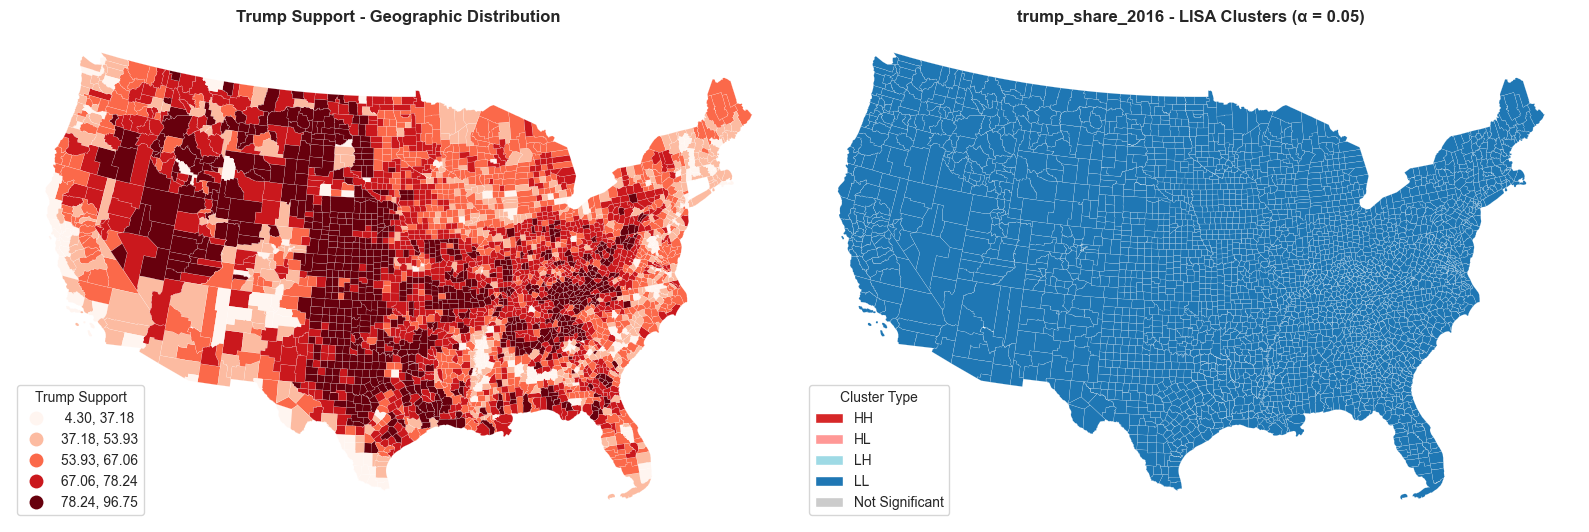


LISA Cluster Summary for trump_share_2016:
trump_share_2016_lisa_cluster
LL    3109
Name: count, dtype: int64

Analyzing spatial clusters of physical distress...


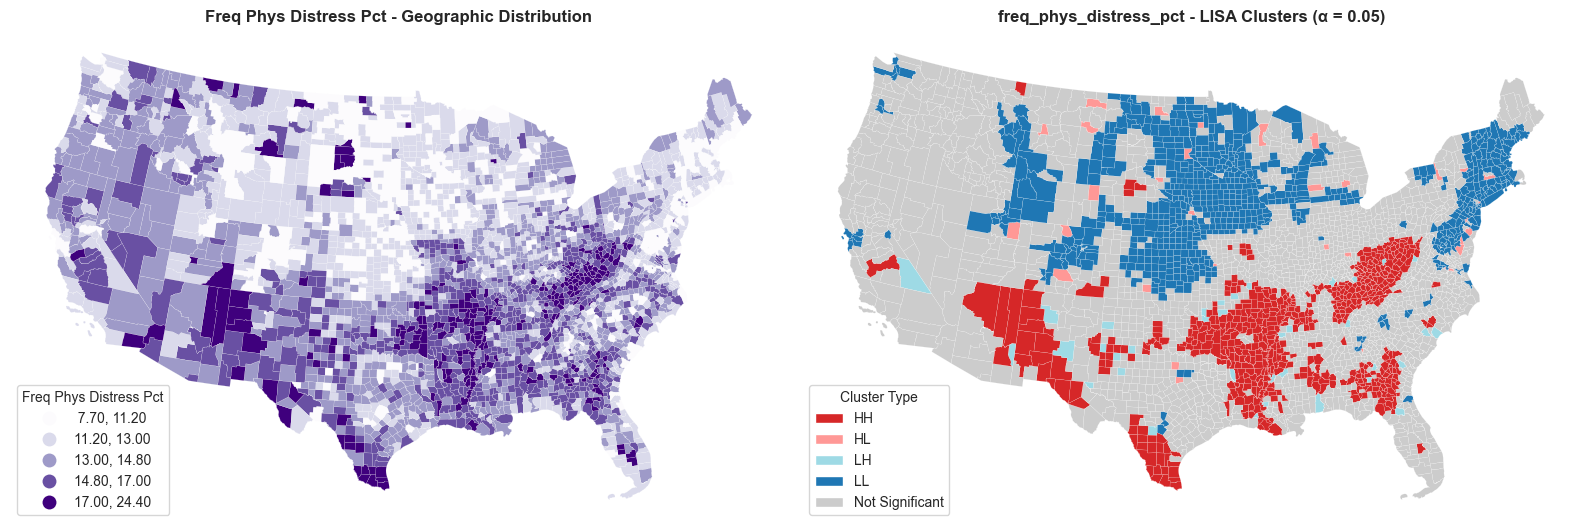


LISA Cluster Summary for freq_phys_distress_pct:
freq_phys_distress_pct_lisa_cluster
Not Significant    1785
LL                  701
HH                  553
LH                   36
HL                   34
Name: count, dtype: int64


In [10]:
def local_moran_analysis(gdf, w, variable, alpha=0.05):
    """Calculate Local Moran's I and identify clusters"""
    
    # Calculate Local Moran's I
    lisa = Moran_Local(gdf[variable].values, w, permutations=999)
    
    # Add LISA statistics to geodataframe
    gdf[f'{variable}_lisa_i'] = lisa.Is
    gdf[f'{variable}_lisa_p'] = lisa.p_sim
    gdf[f'{variable}_lisa_q'] = lisa.q
    
    # Identify significant clusters
    sig = gdf[f'{variable}_lisa_p'] < alpha
    gdf[f'{variable}_lisa_cluster'] = 'Not Significant'
    gdf.loc[sig & (gdf[f'{variable}_lisa_q'] == 1), f'{variable}_lisa_cluster'] = 'HH'  # High-High
    gdf.loc[sig & (gdf[f'{variable}_lisa_q'] == 2), f'{variable}_lisa_cluster'] = 'LH'  # Low-High
    gdf.loc[sig & (gdf[f'{variable}_lisa_q'] == 3), f'{variable}_lisa_cluster'] = 'LL'  # Low-Low
    gdf.loc[sig & (gdf[f'{variable}_lisa_q'] == 4), f'{variable}_lisa_cluster'] = 'HL'  # High-Low
    
    # Create LISA cluster map
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Choose appropriate color scheme based on variable
    if 'trump' in variable.lower() or 'republican' in variable.lower():
        cmap = 'Reds'
        title_prefix = 'Trump Support'
    elif 'distress' in variable.lower() or 'pain' in variable.lower() or 'depression' in variable.lower():
        cmap = 'Purples'  # Use purple for health/distress variables
        title_prefix = variable.replace('_', ' ').title()
    elif 'od' in variable.lower() or 'overdose' in variable.lower():
        cmap = 'YlOrRd'  # Yellow-Orange-Red for mortality
        title_prefix = 'Overdose Rate'
    else:
        cmap = 'viridis'
        title_prefix = variable.replace('_', ' ').title()
    
    # Raw values map - use single-hue sequential color scheme
    gdf.plot(column=variable, scheme='natural_breaks', k=5, cmap=cmap,
             edgecolor='white', linewidth=0.1, ax=axes[0], legend=True,
             legend_kwds={'title': title_prefix, 'loc': 'lower left', 'frameon': True})
    axes[0].set_title(f'{title_prefix} - Geographic Distribution', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # LISA cluster map
    colors = {'HH': '#d62728', 'HL': '#ff9896', 'LH': '#9edae5', 'LL': '#1f77b4', 'Not Significant': '#cccccc'}
    gdf['color'] = gdf[f'{variable}_lisa_cluster'].map(colors)
    gdf.plot(color=gdf['color'], edgecolor='white', linewidth=0.1, ax=axes[1])
    axes[1].set_title(f'{variable} - LISA Clusters (α = {alpha})', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Add legend with better ordering
    from matplotlib.patches import Patch
    cluster_order = ['HH', 'HL', 'LH', 'LL', 'Not Significant']
    legend_elements = [Patch(facecolor=colors[k], label=k) for k in cluster_order if k in colors]
    axes[1].legend(handles=legend_elements, loc='lower left', frameon=True, title='Cluster Type')
    
    plt.tight_layout()
    plt.savefig(reports / f'figures/lisa_cluster_{variable}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    cluster_counts = gdf[f'{variable}_lisa_cluster'].value_counts()
    print(f"\nLISA Cluster Summary for {variable}:")
    print(cluster_counts)
    
    return lisa, gdf

# Analyze Trump 2016 vote share
print("Analyzing spatial clusters of Trump 2016 support...")
lisa_trump_2016, gdf = local_moran_analysis(gdf, w_queen, 'trump_share_2016')

# Analyze overdose rates (if available)
if 'od_1316_rate' in gdf.columns and gdf['od_1316_rate'].notna().sum() > 100:
    print("\nAnalyzing spatial clusters of overdose rates (2013-2016)...")
    lisa_overdose, gdf = local_moran_analysis(gdf, w_queen, 'od_1316_rate')

# Analyze physical distress (if available)
if 'freq_phys_distress_pct' in gdf.columns and gdf['freq_phys_distress_pct'].notna().sum() > 100:
    print("\nAnalyzing spatial clusters of physical distress...")
    lisa_distress, gdf = local_moran_analysis(gdf, w_queen, 'freq_phys_distress_pct')

## 5. Bivariate Spatial Analysis

In [11]:
def bivariate_moran_analysis(gdf, w, var1, var2):
    """Bivariate Moran's I to test spatial correlation between two variables"""
    
    # Global bivariate Moran's I
    moran_bv = Moran_BV(gdf[var1].values, gdf[var2].values, w, permutations=999)
    
    # Get p-value (handle different esda versions)
    p_value = getattr(moran_bv, 'p_sim', getattr(moran_bv, 'p_norm', None))
    
    print(f"\nBivariate Moran's I: {var1} vs {var2}")
    print(f"  I = {moran_bv.I:.4f}")
    if p_value is not None:
        print(f"  p-value = {p_value:.4f}")
        print(f"  Significant: {p_value < 0.05}")
    else:
        print(f"  p-value not available in this version of esda")
    
    # Local bivariate Moran's I
    lisa_bv = Moran_Local_BV(gdf[var1].values, gdf[var2].values, w, permutations=999)
    
    # Add to geodataframe
    gdf[f'bv_{var1}_{var2}_lisa_i'] = lisa_bv.Is
    gdf[f'bv_{var1}_{var2}_lisa_p'] = lisa_bv.p_sim
    gdf[f'bv_{var1}_{var2}_lisa_q'] = lisa_bv.q
    
    # Create bivariate LISA cluster map
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Variable 1 map - single-hue sequential
    gdf.plot(column=var1, scheme='natural_breaks', k=5, cmap='Blues',
             edgecolor='white', linewidth=0.1, ax=axes[0], legend=True,
             legend_kwds={'title': var1, 'loc': 'lower left', 'frameon': True})
    axes[0].set_title(f'{var1}', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Variable 2 map - single-hue sequential
    gdf.plot(column=var2, scheme='natural_breaks', k=5, cmap='Reds',
             edgecolor='white', linewidth=0.1, ax=axes[1], legend=True,
             legend_kwds={'title': var2, 'loc': 'lower left', 'frameon': True})
    axes[1].set_title(f'{var2}', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Bivariate LISA clusters
    sig = gdf[f'bv_{var1}_{var2}_lisa_p'] < 0.05
    gdf['bv_cluster'] = 'Not Significant'
    gdf.loc[sig & (gdf[f'bv_{var1}_{var2}_lisa_q'] == 1), 'bv_cluster'] = 'HH'
    gdf.loc[sig & (gdf[f'bv_{var1}_{var2}_lisa_q'] == 2), 'bv_cluster'] = 'LH'
    gdf.loc[sig & (gdf[f'bv_{var1}_{var2}_lisa_q'] == 3), 'bv_cluster'] = 'LL'
    gdf.loc[sig & (gdf[f'bv_{var1}_{var2}_lisa_q'] == 4), 'bv_cluster'] = 'HL'
    
    colors = {'HH': '#8b0000', 'HL': '#ff6347', 'LH': '#4169e1', 'LL': '#87ceeb', 'Not Significant': '#d3d3d3'}
    gdf['bv_color'] = gdf['bv_cluster'].map(colors)
    gdf.plot(color=gdf['bv_color'], edgecolor='white', linewidth=0.1, ax=axes[2])
    axes[2].set_title(f'Bivariate LISA: {var1} vs {var2}')
    axes[2].axis('off')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=colors['HH'], label='HH: High-High'),
        Patch(facecolor=colors['HL'], label='HL: High-Low'),
        Patch(facecolor=colors['LH'], label='LH: Low-High'),
        Patch(facecolor=colors['LL'], label='LL: Low-Low'),
        Patch(facecolor=colors['Not Significant'], label='Not Significant')
    ]
    axes[2].legend(handles=legend_elements, loc='lower left')
    
    plt.tight_layout()
    plt.savefig(reports / f'figures/bivariate_lisa_{var1}_{var2}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Summary
    print("\nBivariate LISA Cluster Counts:")
    print(gdf['bv_cluster'].value_counts())
    
    return moran_bv, lisa_bv, gdf

# Analyze relationship between overdose rates and Trump vote share
if 'od_1316_rate' in gdf.columns and gdf['od_1316_rate'].notna().sum() > 100:
    print("\nBivariate analysis: Overdose rates vs Trump 2016 support...")
    moran_bv, lisa_bv, gdf = bivariate_moran_analysis(gdf, w_queen, 'od_1316_rate', 'trump_share_2016')

# Analyze relationship between physical distress and Trump vote share
if 'freq_phys_distress_pct' in gdf.columns and gdf['freq_phys_distress_pct'].notna().sum() > 100:
    print("\nBivariate analysis: Physical distress vs Trump 2016 support...")
    moran_bv2, lisa_bv2, gdf = bivariate_moran_analysis(gdf, w_queen, 'freq_phys_distress_pct', 'trump_share_2016')


Bivariate analysis: Physical distress vs Trump 2016 support...

Bivariate Moran's I: freq_phys_distress_pct vs trump_share_2016
  I = nan


AttributeError: 'Moran_BV' object has no attribute 'p_norm'

## 6. Hot Spot Analysis (Getis-Ord Gi*)

In [ ]:
from esda.getisord import G_Local

def hotspot_analysis(gdf, w, variable):
    """Getis-Ord Gi* hot spot analysis"""
    
    # Calculate Gi*
    g = G_Local(gdf[variable].values, w, permutations=999, star=True)
    
    # Add to geodataframe
    gdf[f'{variable}_gi'] = g.Gs
    gdf[f'{variable}_gi_p'] = g.p_sim
    gdf[f'{variable}_gi_z'] = g.Zs
    
    # Classify hot/cold spots based on z-scores and p-values
    gdf[f'{variable}_hotspot'] = 'Not Significant'
    sig = gdf[f'{variable}_gi_p'] < 0.05
    gdf.loc[sig & (gdf[f'{variable}_gi_z'] > 0), f'{variable}_hotspot'] = 'Hot Spot'
    gdf.loc[sig & (gdf[f'{variable}_gi_z'] < 0), f'{variable}_hotspot'] = 'Cold Spot'
    
    # Further classify by confidence level
    gdf[f'{variable}_hotspot_conf'] = 'Not Significant'
    # 99% confidence
    gdf.loc[(gdf[f'{variable}_gi_p'] < 0.01) & (gdf[f'{variable}_gi_z'] > 0), f'{variable}_hotspot_conf'] = 'Hot Spot - 99% Conf'
    gdf.loc[(gdf[f'{variable}_gi_p'] < 0.01) & (gdf[f'{variable}_gi_z'] < 0), f'{variable}_hotspot_conf'] = 'Cold Spot - 99% Conf'
    # 95% confidence
    gdf.loc[(gdf[f'{variable}_gi_p'] < 0.05) & (gdf[f'{variable}_gi_p'] >= 0.01) & (gdf[f'{variable}_gi_z'] > 0), 
            f'{variable}_hotspot_conf'] = 'Hot Spot - 95% Conf'
    gdf.loc[(gdf[f'{variable}_gi_p'] < 0.05) & (gdf[f'{variable}_gi_p'] >= 0.01) & (gdf[f'{variable}_gi_z'] < 0), 
            f'{variable}_hotspot_conf'] = 'Cold Spot - 95% Conf'
    # 90% confidence
    gdf.loc[(gdf[f'{variable}_gi_p'] < 0.10) & (gdf[f'{variable}_gi_p'] >= 0.05) & (gdf[f'{variable}_gi_z'] > 0), 
            f'{variable}_hotspot_conf'] = 'Hot Spot - 90% Conf'
    gdf.loc[(gdf[f'{variable}_gi_p'] < 0.10) & (gdf[f'{variable}_gi_p'] >= 0.05) & (gdf[f'{variable}_gi_z'] < 0), 
            f'{variable}_hotspot_conf'] = 'Cold Spot - 90% Conf'
    
    # Create hot spot map
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    colors = {
        'Hot Spot - 99% Conf': '#b30000',
        'Hot Spot - 95% Conf': '#e34a33',
        'Hot Spot - 90% Conf': '#fc8d59',
        'Not Significant': '#ffffcc',
        'Cold Spot - 90% Conf': '#91bfdb',
        'Cold Spot - 95% Conf': '#4575b4',
        'Cold Spot - 99% Conf': '#253494'
    }
    
    gdf['hotspot_color'] = gdf[f'{variable}_hotspot_conf'].map(colors)
    gdf.plot(color=gdf['hotspot_color'], edgecolor='white', linewidth=0.1, ax=ax)
    ax.set_title(f'Hot Spot Analysis (Getis-Ord Gi*): {variable}')
    ax.axis('off')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[k], label=k) for k in colors.keys()]
    ax.legend(handles=legend_elements, loc='lower left')
    
    plt.tight_layout()
    plt.savefig(reports / f'figures/hotspot_{variable}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Summary
    print(f"\nHot Spot Analysis Summary for {variable}:")
    print(gdf[f'{variable}_hotspot_conf'].value_counts())
    
    return g, gdf

# Identify hot spots of Trump support
print("\nHot spot analysis: Trump 2016 support...")
g_trump, gdf = hotspot_analysis(gdf, w_queen, 'trump_share_2016')

# Identify hot spots of overdose rates
if 'od_1316_rate' in gdf.columns and gdf['od_1316_rate'].notna().sum() > 100:
    print("\nHot spot analysis: Overdose rates (2013-2016)...")
    g_overdose, gdf = hotspot_analysis(gdf, w_queen, 'od_1316_rate')

# Identify hot spots of physical distress
if 'freq_phys_distress_pct' in gdf.columns and gdf['freq_phys_distress_pct'].notna().sum() > 100:
    print("\nHot spot analysis: Physical distress...")
    g_distress, gdf = hotspot_analysis(gdf, w_queen, 'freq_phys_distress_pct')

## 7. Export Results for Web Visualization

In [ ]:
def prepare_web_export(gdf):
    """Prepare data for web visualization"""
    
    # Select columns for web export (filter to what's actually available)
    web_columns = [
        'fips', 'county_name', 'state_fips', 'geometry',
        # Electoral
        'trump_share_2016', 'trump_share_2020', 'trump_shift_16_20',
        'trump_margin_2016', 'trump_margin_2020',
        # Pain/distress metrics
        'od_1316_rate', 'od_1720_rate', 'od_rate_change',
        'freq_phys_distress_pct', 'freq_mental_distress_pct',
        'arthritis_pct', 'depression_pct', 'diabetes_pct',
        # County Health Rankings
        'chr_drug_overdose_deaths_per_100k', 'chr_poor_physical_health_days',
        'chr_poor_mental_health_days',
        # LISA clusters (if computed)
        'trump_share_2016_lisa_cluster',
        'od_1316_rate_lisa_cluster',
        'freq_phys_distress_pct_lisa_cluster',
        # Hot spots (if computed)
        'trump_share_2016_hotspot_conf',
        'od_1316_rate_hotspot_conf',
        'freq_phys_distress_pct_hotspot_conf',
        # Controls
        'rucc', 'rural', 'rucc_category', 'ba_plus_pct', 'median_income'
    ]
    
    # Filter to available columns
    available_cols = [c for c in web_columns if c in gdf.columns]
    print(f"Exporting {len(available_cols)} columns: {available_cols[:10]}...")
    
    web_gdf = gdf[available_cols].copy()
    
    # Convert back to WGS84 for web mapping
    if web_gdf.crs.to_epsg() != 4326:
        web_gdf = web_gdf.to_crs('EPSG:4326')
    
    # Simplify geometry to reduce file size
    web_gdf['geometry'] = web_gdf['geometry'].simplify(0.01, preserve_topology=True)
    
    # Round numeric columns
    numeric_cols = web_gdf.select_dtypes(include=[np.number]).columns
    web_gdf[numeric_cols] = web_gdf[numeric_cols].round(2)
    
    # Export as GeoJSON
    output_path = project_root / 'web' / 'assets' / 'counties_esda.geojson'
    output_path.parent.mkdir(parents=True, exist_ok=True)
    web_gdf.to_file(output_path, driver='GeoJSON')
    
    print(f"✅ Exported {len(web_gdf)} counties to {output_path}")
    print(f"   File size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")
    
    return web_gdf

# Export the enriched dataset with spatial analysis results
web_data = prepare_web_export(gdf)

## 8. Summary of Findings

Key spatial patterns identified:

### Global Spatial Autocorrelation
- Review the Moran's I table above to see which variables show significant spatial clustering
- Variables with high positive Moran's I indicate strong spatial autocorrelation (similar values cluster together)
- Variables with negative Moran's I show spatial dispersion (dissimilar values are neighbors)

### Local Clustering (LISA)
- **HH (High-High)**: Counties with high values surrounded by high-value neighbors
- **LL (Low-Low)**: Counties with low values surrounded by low-value neighbors  
- **HL (High-Low)**: High-value outliers surrounded by low-value neighbors
- **LH (Low-High)**: Low-value outliers surrounded by high-value neighbors

### Bivariate Relationships
- Bivariate LISA maps show where two variables co-occur spatially
- HH clusters indicate counties where both variables are high AND spatially clustered
- These are the key "hotspots" for the pain-politics relationship

### Hot Spot Analysis (Getis-Ord Gi*)
- More focused on statistical hot spots vs cold spots
- Multi-level confidence intervals (90%, 95%, 99%)
- Useful for identifying statistically significant geographic concentrations

### Next Steps
1. Review the generated maps in `reports/figures/`
2. Examine specific high-value clusters for qualitative interpretation
3. Use these spatial patterns as inputs for regression models (Notebook 04)
4. Explore interactive visualization in the web interface
